# Importer les librairies

In [78]:
import pandas as pd 
from scipy import stats
from scipy.stats import chi2_contingency
import numpy as np
pd.set_option('mode.chained_assignment', None) # ignorer certains warnings

# Data
from sklearn import datasets

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning
import statsmodels.api as sm
from sklearn.tree import DecisionTreeClassifier, plot_tree

# Importer les données

In [79]:
data = pd.read_csv("./titanic.csv")
data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


# Questions

## 1. Préparation des données

Remplissez la function `preprocess` ci-dessus. Celle-ci doit:
1. Supprimez les colonnes `PassengerId`, `Name`, `Ticket`, `Cabin`.
2. Supprimez les lignes contenant au moins une valeur manquante.
3. Créer une variable `FamilySize` qui est correspond à `SibSp` + `Parch` + 1. Supprimez les variables `SibSp` et `Parch`.
4. Recalculer le prix du billet `Fare` en divisant `Fare` par `FamilySize`.
5. Encoder les variables qualitatives `Sex` et `Embarked` avec l'argument `drop_first=True`.

In [80]:
def preprocess(data: pd.DataFrame) -> pd.DataFrame:
    
    """La fonction prépare les données à l'analyse.
    
    Args:
        data (pd.DataFrame): La dataframe originale
        
    Returns:
        pd.DataFrame: La dataframe preprocessé et prête à être analysée.
    """
    
    # Faire une copy de la dataframe originale
    data_preprocessed = data.copy()
    
    # Supprimez les variables `PassengerId`, `Name`, `Ticket` & `Cabin`
    data_preprocessed.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'], inplace=True)
    
    # Supprimez lignes contenant au moins une valeur manquante
    data_preprocessed.dropna(axis=0, inplace=True) # on supprime les lignes (axe 0) et pas les colonnes 
    
    # Créer une variable `FamilySize` et supprimez les variables `SibSp` et `Parch`
    data_preprocessed['FamilySize'] = data['SibSp'] + data['Parch'] + 1
    data_preprocessed.drop(columns=['SibSp', 'Parch'], inplace=True)
    
    # Recalculer le prix du billet
    data_preprocessed['Fare'] = data_preprocessed['Fare'] / data_preprocessed['FamilySize']
    
    # Encoded (OHE) `Sex` et `Embarked`
    data_preprocessed = pd.get_dummies(data_preprocessed, columns=['Sex', 'Embarked'], drop_first=True, dtype=int)
    
    
    # CHECK: NE PAS TOUCHER
    for col in ["PassengerId", "Name", "Ticket", "Cabin", "SibSp", "Parch"]:
        assert col not in data_preprocessed, f"{col} n'a pas été retiré."
    assert data_preprocessed.isna().sum().sum() == 0, "Il reste encore des NaN à supprimer."
    assert "FamilySize" in data_preprocessed.columns, "La colonne `FamilySize` n'a pas été créée."
    assert data_preprocessed.loc[0, "Fare"] == 3.625, "La colonne `Fare` n'a pas été recalculée."
    for col in [col for col in data_preprocessed if col.startswith("Embarked")]:
        assert data_preprocessed[col].nunique() == 2, f"{col} n'a pas été encodé."
    for col in [col for col in data_preprocessed if col.startswith("Sex")]:
        assert data_preprocessed[col].nunique() == 2, f"{col} n'a pas été encodé."
    
    return data_preprocessed

Le résultat de la function doit vous donner exactement le tableau ci-dessous.

In [81]:
# Preprocess les données à l'aide de la function `preprocess`
data_clean = preprocess(data)
display(data_clean)

,Survived,Pclass,Age,Fare,FamilySize,Sex_male,Embarked_Q,Embarked_S
0,0,3,22.0,3.625000,2,1,0,1
1,1,1,38.0,35.641650,2,0,0,0
2,1,3,26.0,7.925000,1,0,0,1
3,1,1,35.0,26.550000,2,0,0,1
4,0,3,35.0,8.050000,1,1,0,1
...,...,...,...,...,...,...,...,...
885,0,3,39.0,4.854167,6,0,1,0
886,0,2,27.0,13.000000,1,1,0,1
887,1,1,19.0,30.000000,1,0,0,1
889,1,1,26.0,30.000000,1,1,0,0


## 2. Inférence statistique (4 pts)

In [82]:
# variables globales
ALPHA = 0.05

### Q1: L'âge moyen des passagers du Titanic est-il est le même que l'âge moyen de la population en 1912 (28 ans)?**

### Variable d'intérêt
La variable d'intérêt ici est "Age", qui est une variable quantitative continue.

### Visualisation de la variable

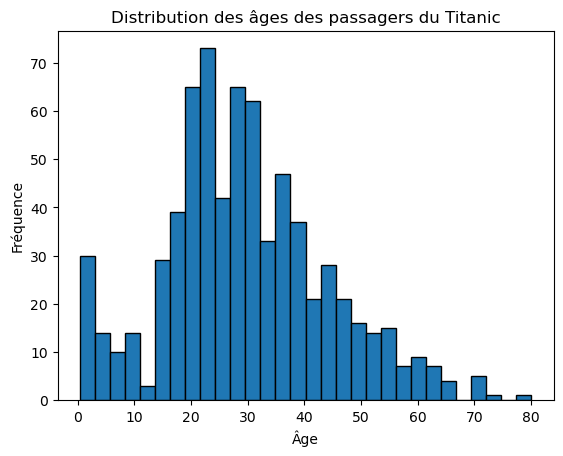

In [83]:
plt.hist(data_clean['Age'], bins=30, edgecolor='black')
plt.title('Distribution des âges des passagers du Titanic')
plt.xlabel('Âge')
plt.ylabel('Fréquence')
plt.show()

### Hypothèse nulle et alternative
H0: μ = 28
H1: μ != 28

### Test statistique approprié
Le test statistique approprié est le t-test

### Validation des assumptions
Les assumptions suivantes sont validées pour ce test:
- Les données sont quantitatives et sont obtenues à partir d’un échantillon aléatoire.
- Le scatter plot montre que les données sont approximativement liées linéairement.
- Il n’y a pas de valeurs abberantes dans les données.
- Les variables doivent chacune suivre une loi normale

### Calcul des valeurs et prise de décision

In [84]:
# moyenne de l'âge de la population en 1912
mu = 28
# âge des passagers du Titanic
age = data_clean['Age']

t, p_valeur = stats.ttest_1samp(age, popmean=mu)
sample_mean = np.mean(age)
d_cohen = (sample_mean - mu) / np.std(age)

print(f"La statistique t est de : {round(t, 3)}")
print(f"La p-valeur associée est de : {round(p_valeur, 3)}")
if p_valeur < ALPHA:
    print(f"Avec un seuil alpha {ALPHA}, on rejète l'hypothèse nulle.")
else:
    print(f"Avec un seuil alpha {ALPHA}, on ne rejète pas l'hypothèse nulle.")
print(f"Moyenne d'âge de l'échantillon : {round(sample_mean, 3)}")
print(f"Taille de l'effet (d de Cohen) : {round(d_cohen, 3)}")

La statistique t est de : 3.023
La p-valeur associée est de : 0.003
Avec un seuil alpha 0.05, on rejète l'hypothèse nulle.
Moyenne d'âge de l'échantillon : 29.642
Taille de l'effet (d de Cohen) : 0.113


### Interprétation des résultats et évaluation de la taille des effets
L'âge moyen des passagers du Titanic est statistiquement significativement différent de 28 ans, mais la différence d'âge moyen entre les passagers du Titanic et la population en 1912 est petit en terme d'écart-type.

Cela pourrait suggérer que l'âge des passagers du Titanic reflétait assez bien la distribution des âges dans la population en général en 1912, même si l'âge moyen était légèrement différent.

### Q2: La survie dépend-elle de la classe du passager?

### Variables d'intérêt
Les variables d'intérêts sont la variable de survie et la classe du passager. Ces deux variables sont qualitatives: nominale pour "Survived" et ordinale pour "Pclass".

### Visualisation des variables

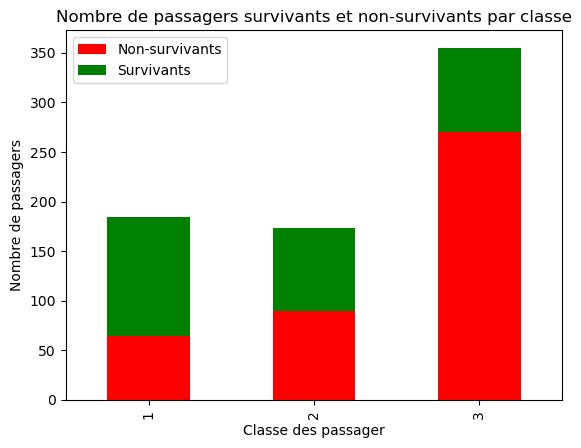

In [85]:

survival_data = data_clean.groupby(['Pclass', 'Survived']).size().unstack()

# Creating a bar plot
fig, ax = plt.subplots()
survival_data.plot(kind='bar', stacked=True, ax=ax, color=['red', 'green'])

# Customizing the plot
ax.set_xlabel('Classe des passager')
ax.set_ylabel('Nombre de passagers')
ax.set_title('Nombre de passagers survivants et non-survivants par classe')
ax.legend(["Non-survivants", "Survivants"])


### Hypothèse nulle et alternative
H0: μ = La survie d'un passager et le type de sa classe sont indépendants l'un de l'autre.
H1: μ != La survie d'un passager et le type de sa classe ne sont pas indépendants l'un de l'autre.
### Test statistique approprié
Le test statistique approprié ici est le 𝜒2 independence test ou "chi-square".
### Validation des assumptions
Les assumptions suivantes sont validées pour ce test:
- Les échantillons sont aléatoires.
- Pour chaque combinaison des niveaux des variables, nous avons besoin d’au moins 5 valeurs.


### Calcul des valeurs et prise de décision

In [86]:
# Créer un tableau de contingence pour les variables "Survived" et "Pclass"
contingency_table = pd.crosstab(data_clean['Survived'], data_clean['Pclass'])

# Effectuer le test du chi-carré
chi2, p, _, _ = chi2_contingency(contingency_table)


# Calcul de la taille de l'effet Cramer's V
n = data_clean.shape[0]  # Taille totale de l'échantillon
k, r = contingency_table.shape  # Nombre de colonnes et de lignes dans le tableau
# Calcul du coefficient de Cramer
cramers_v = np.sqrt(chi2 / (n * (min(k, r) - 1)))

# Afficher les résultats
print(f"La statistique du test Chi-Squared : {round(chi2, 3)}")
print(f"La p-valeur associée est de : {p}")

# Interpréter les résultats
if p < ALPHA:
    print("Il y a une association significative entre les personnes qui ont survécus et leur classe passager.")
else:
    print("Il n'y a pas de preuve significative d'association entre les personnes qui ont survécus et leur classe passager.")
    
if cramers_v <= 0.2:
    print("La taille de l'effet est considérée comme petite.")
elif 0.2 < cramers_v <= 0.6:
    print("La taille de l'effet est considérée comme moyenne.")
elif 0.6 < cramers_v <= 1:
    print("La taille de l'effet est considérée comme grande.")


La statistique du test Chi-Squared : 91.081
La p-valeur associée est de : 1.6675060315554636e-20
Il y a une association significative entre les personnes qui ont survécus et leur classe passager.
La taille de l'effet est considérée comme moyenne.


### Interprétation des résultats et évaluation de la taille des effets
Il existe une association statistiquement significative de force moyenne entre la classe des passagers et leur taux de survie.
La taille de l'effet est considérée comme moyenne suggère que la classe du passager a effectiement une influence modérée par rapport à la survie de ce dernier.

### Q3: Existe-t-il une différence d'âge entre les passagers qui ont survécu et les passagers décédés?

### Variables d'intérêt
Les variables d'intérêt sont ici Age (variable quantitative continue) et Survived (variable quanlitative catégorielle)

### Visualisation des variables

([<matplotlib.axis.XTick at 0x1d340dc7410>,
 [Text(0, 0, 'Died'), Text(1, 0, 'Survived')])

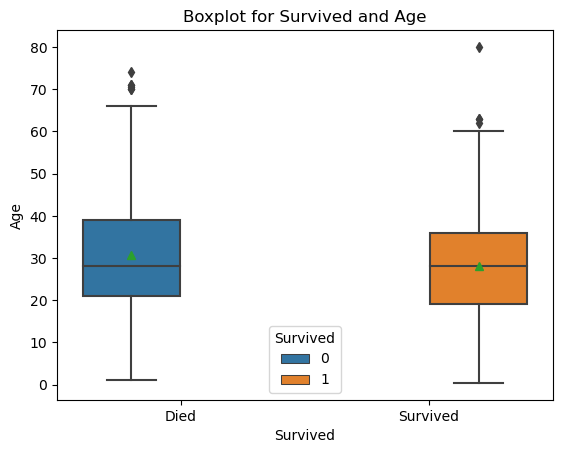

In [87]:
sns.boxplot(
    x='Survived', 
    y='Age', 
    data=data_clean,
    showmeans=True,
    hue='Survived',
    #legend=False,
)
plt.title("Boxplot for Survived and Age")
plt.xticks(ticks=[0,1], labels=['Died', 'Survived'])

### Hypothèse nulle et alternative
Hypothèse nulle (H0) : Il n'y a pas de différence significative entre l'âge des passagers qui ont survécu et ceux qui sont décédés.
Hypothèse alternative (H1) : Il y a une différence significative entre l'âge des passagers qui ont survécu et ceux qui sont décédés
### Test statistique approprié
Le test statistique approprié est le two-sample t-test
### Validation des assumptions
Les assumptions suivantes sont validées pour ce test:
Les échantillons sont aléatoires et pas forcément de même taille
Les échantillons sont indépendants les uns des autres.
La taille des échantillons est supérieure à 30, ou les populations sont normalement distribuées.


### Calcul des valeurs et prise de décision

In [88]:
survived = data_clean[data_clean['Survived'] == 1]['Age']
died = data_clean[data_clean['Survived'] == 0]['Age']

t, p_valeur = stats.ttest_ind(
    survived,
    died,
    alternative="two-sided",
    equal_var=False
)
survived_mean = np.mean(survived)
died_mean = np.mean(died)
variance_survived = np.var(survived, ddof=1)
variance_died = np.var(died, ddof=1)
n_survived = len(survived)
n_died = len(died)
d_cohen = (np.mean(survived) - np.mean(died)) / np.sqrt(((n_survived-1)*variance_survived + (n_died-1)*variance_died) / (n_survived+n_died-2))

print(f"La moyenne d'âge des survivants est de : {round(survived_mean, 3)}")
print(f"La moyenne d'âge des non-survivants est de : {round(died_mean, 3)}")
print(f"La statistique t est de : {round(t, 3)}")
print(f"La p-valeur associée est de : {round(p_valeur, 3)}")
if p_valeur < ALPHA:
    print(F"Avec un seuil alpha {ALPHA}, on rejète l'hypothèse nulle.")
else:
    print(f"Avec un seuil alpha {ALPHA}, on ne rejète pas l'hypothèse nulle.")
print(f"Taille de l'effet (d de Cohen) : {round(d_cohen, 3)}")

La moyenne d'âge des survivants est de : 28.193
La moyenne d'âge des non-survivants est de : 30.626
La statistique t est de : -2.184
La p-valeur associée est de : 0.029
Avec un seuil alpha 0.05, on rejète l'hypothèse nulle.
Taille de l'effet (d de Cohen) : -0.168


### Interprétation des résultats et évalutaion de la taille des effets
Il semble y avoir une différence significative entre l'âge des passagers qui ont survécus et ceux qui sont décédés lors du naufrage, les survivants étant en moyenne plus jeunes. 
Malgré cela, l'âge n'a pas forcément directement influencé les chances de survie. 
Le d de Cohen suggère qu'il y a une petite différence statistiquement significative entre l'âge moyen des survivants et des non-survivants sur le Titanic.

### Q4: Existe-t-il une relation entre l'âge des passagers et le prix des billets?

### Variables d'intérêt
Les variables d'intérêt sont dans ce cas l'âge des passagers et le prix des billets, toutes deux des variables quantitatives.

### Visualisation des variables

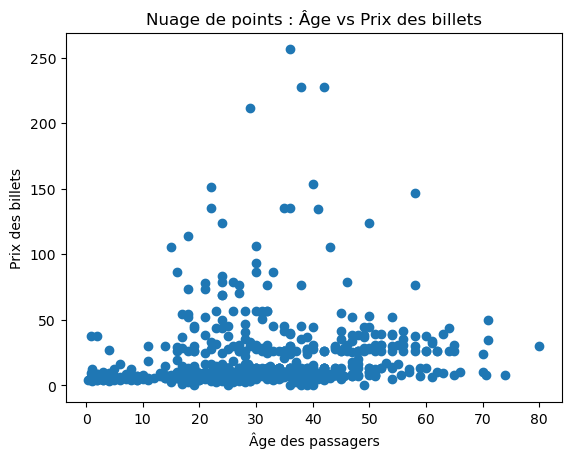

In [89]:
# Sélectionner les colonnes âge et prix des billets
age = data_clean['Age']
prix_billets = data_clean['Fare']

outlier = data_clean[data_clean['Fare'] > 500] # suppression valeurs abberantes

prix_billets = prix_billets.drop(outlier.index)
age = age.drop(outlier.index)

# Tracer le nuage de points pour la visualisation
plt.scatter(age, prix_billets)
plt.xlabel('Âge des passagers')
plt.ylabel('Prix des billets')
plt.title('Nuage de points : Âge vs Prix des billets')
plt.show()


### Hypothèse nulle et alternative
H0: p = 0, il n'y pas de corrélation significative entre l'âge et le prix des billets.
H1:p ≠ 0, il y a une corrélation significative entre l'âge et le prix des billets.

### Test statistique approprié
Le test statistique approprié est le t-test

### Validation des assumptions
Les assumptions suivantes sont validées pour ce test:
Les données sont quantitatives et sont obtenues à partir d'un échantillon aléatoire.
Le scatter plot montre que les données sont approximativement liées linéairement.
Il n'y a pas de valeurs abberantes dans les données.
Les variables doivent chacune suivre une loi normale.



### Calcul des valeurs et prise de décision

In [90]:

# Calcul des variables
var1 = data_clean["Age"]
var2 = data_clean["Fare"]
r = var1.corr(var2) # la corrélation entre les 2 variables
n = len(var1) # la taille de l'échantillon

# Calcul t-test
r, p_valeur = stats.pearsonr(
    var1, # `âge`
    var2 # `prix des billets`
)

# Afficher les valeurs

print(f"La corrélation entre l'âge et le prix des billets est de {r}.")

print("\n")

print("La p-valeur est:", p_valeur)

# Si p-valeur < alpha, on rejette l'hypothèse nulle
if p_valeur < ALPHA:
    print(f"Avec un seuil alpha à {ALPHA}, on rejette l'hypothèse nulle.")
# Sinon, on ne rejette pas l'hypothèse nulle
else:
    print(f"Avec un seuil alpha à {ALPHA}, on ne rejette pas l'hypothèse nulle.")

# Interprétation des résultats et évaluation de la taille de l'effet
valeur_reference=20
mean_difference = np.mean(var1) - valeur_reference
std_deviation = np.std(var1, ddof=1)  # Utiliser ddof=1 pour calculer l'écart-type de l'échantillon (n-1)
effect_size = mean_difference / std_deviation

# Afficher les résultats
print(f"Taille de l'effet (Cohen's d) : {effect_size}")



La corrélation entre l'âge et le prix des billets est de 0.14563315923055964.


La p-valeur est: 9.620859091068543e-05
Avec un seuil alpha à 0.05, on rejette l'hypothèse nulle.
Taille de l'effet (Cohen's d) : 0.6652961662724577


### Interprétation des résultats et évalutaion de la taille des effets
Il y a une corrélation significative entre l'âge et le prix des billets dans la population.
Dans ce cas, la taille d'effet est modérée. Cela indique qu'il existe une relation modérée entre l'âge des passagers et le prix des billets, selon les résultats de notre t-test.

Pour chacune des questions 1 à 4 ci-dessus, argumenter de manière statistique en effectuant chacune des étapes suivantes:
1. Identifier la ou les variables d'intérêt et spécifier le type.
2. Réaliser une visualisation appropriée selon la ou les variables.
3. Enoncer une hypothèse nulle et une hypothèse alternative considérant la ou les variables identifiées.
4. Identifier le test statistique approprié selon les hypothèses énoncées.
5. Vérifier la validation des assumptions selon le test identifié.
6. Calculer la statistique ainsi que la p-valeur.
7. Prendre une décision à partir de la p-valeur et d'un seuil alpha de 5%.
8. Interpréter le résultat et évaluer la taille de l'effet.

Quelques liens utiles pour la taille de l'effet:
* [https://rpsychologist.com/cohend/](https://rpsychologist.com/cohend/)
* [https://datatab.net/tutorial/effect-size-independent-t-test](https://datatab.net/tutorial/effect-size-independent-t-test)
* [https://www.simplypsychology.org/effect-size.html](https://www.simplypsychology.org/effect-size.html)

## 3. Data mining (2 pts)

**Q1: Effectuer une analyse statistique à l'aide de la régression logistique avec comme variable dépendente la variable `Survived`. Interpréter les coefficients et discuter de leur importance statistique en vous appuyant sur leur p-valeur.**

Voici la régression logistique de la variable dépendante "Survived":

In [91]:
# Séparer les features et la target
X = data_clean.drop(columns=["Survived"]) # toutes les colonnes sauf var survived, qui est notre target
y = data_clean["Survived"]

# Générer un model de régression logistique
model = sm.Logit(
    y,
    sm.add_constant(X) # il faut rajouter une constante, qui n'est pas là par défaut
)

# Fit le model
model_fit = model.fit()

# Quel est le résumé?
print(model_fit.summary())

Optimization terminated successfully.
         Current function value: 0.445519
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:               Survived   No. Observations:                  712
Model:                          Logit   Df Residuals:                      704
Method:                           MLE   Df Model:                            7
Date:                Thu, 21 Dec 2023   Pseudo R-squ.:                  0.3398
Time:                        12:29:41   Log-Likelihood:                -317.21
converged:                       True   LL-Null:                       -480.45
Covariance Type:            nonrobust   LLR p-value:                 1.324e-66
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.7251      0.659      8.691      0.000       4.434       7.016
Pclass        -1.1795      0.

### Calcul des coefficients et valeurs

In [92]:
# On récupère les coefficients
coefs = model_fit.params.tolist()


print(f" Les coefficients sont:  {coefs}")

# On calcule le odds ratio
odds_ratio = np.exp(model_fit.params)

pd.DataFrame(odds_ratio, columns=["Odds ratio"])


 Les coefficients sont:  [5.725098601140173, -1.1794912526464787, -0.04183154633377719, 0.0030104675944640307, -0.19340938754372625, -2.6547461014025107, -0.8290537688375385, -0.4111051053739088]


,Odds ratio
const,306.463481
Pclass,0.307435
Age,0.959031
Fare,1.003015
FamilySize,0.824145
Sex_male,0.070317
Embarked_Q,0.436462
Embarked_S,0.662917


L'**odd ratio** peut être défini comme le rapport de côtes de probabilité que le passager soit un survivant ou pas. On l'interprète de la manière suivante:
* OR = 1: la survie du passager est indépendante de la variable : Prix
* OR > 1: la survie du passager est plus probable pour la variable: Aucun
* OR < 1: la survie du passager n'est pas probable pour la variable: Classe passagère, Age, Taille de famille, Sexe masculin, Embarqué secteur Q, Embarqué secteur S

La **p-valeur** est la probabilité pour un modèle statistique donné sous l'hypothèse nulle d'obtenir une valeur au moins aussi extrême que celle observée. On l'interprète de manière suivante:
* Soit p>0,05: la différence n'est pas significative, on ne peut pas conclure à une différence pour les variables: Prix, taille de famille, Embarqué secteur Q, Embarqué secteur S.
* Soit p≤0,05: la différence est significative, le risque pris est précisé, sa valeur est appelée degré de signification pour les variables: Classe passagère, Age, Sexe masculin.

### Q2: Effectuer une analyse statistique à l'aide d'un arbre de classification avec comme variable dépendente la variable `Survived` et une profondeur maximale de 4. Visualiser l'arbre et expliquer quelques décisions.

### Arbre de classification

Voici l'arbre de classification de la variable dépendante "Survived" d'une profondeur maximale de 4:

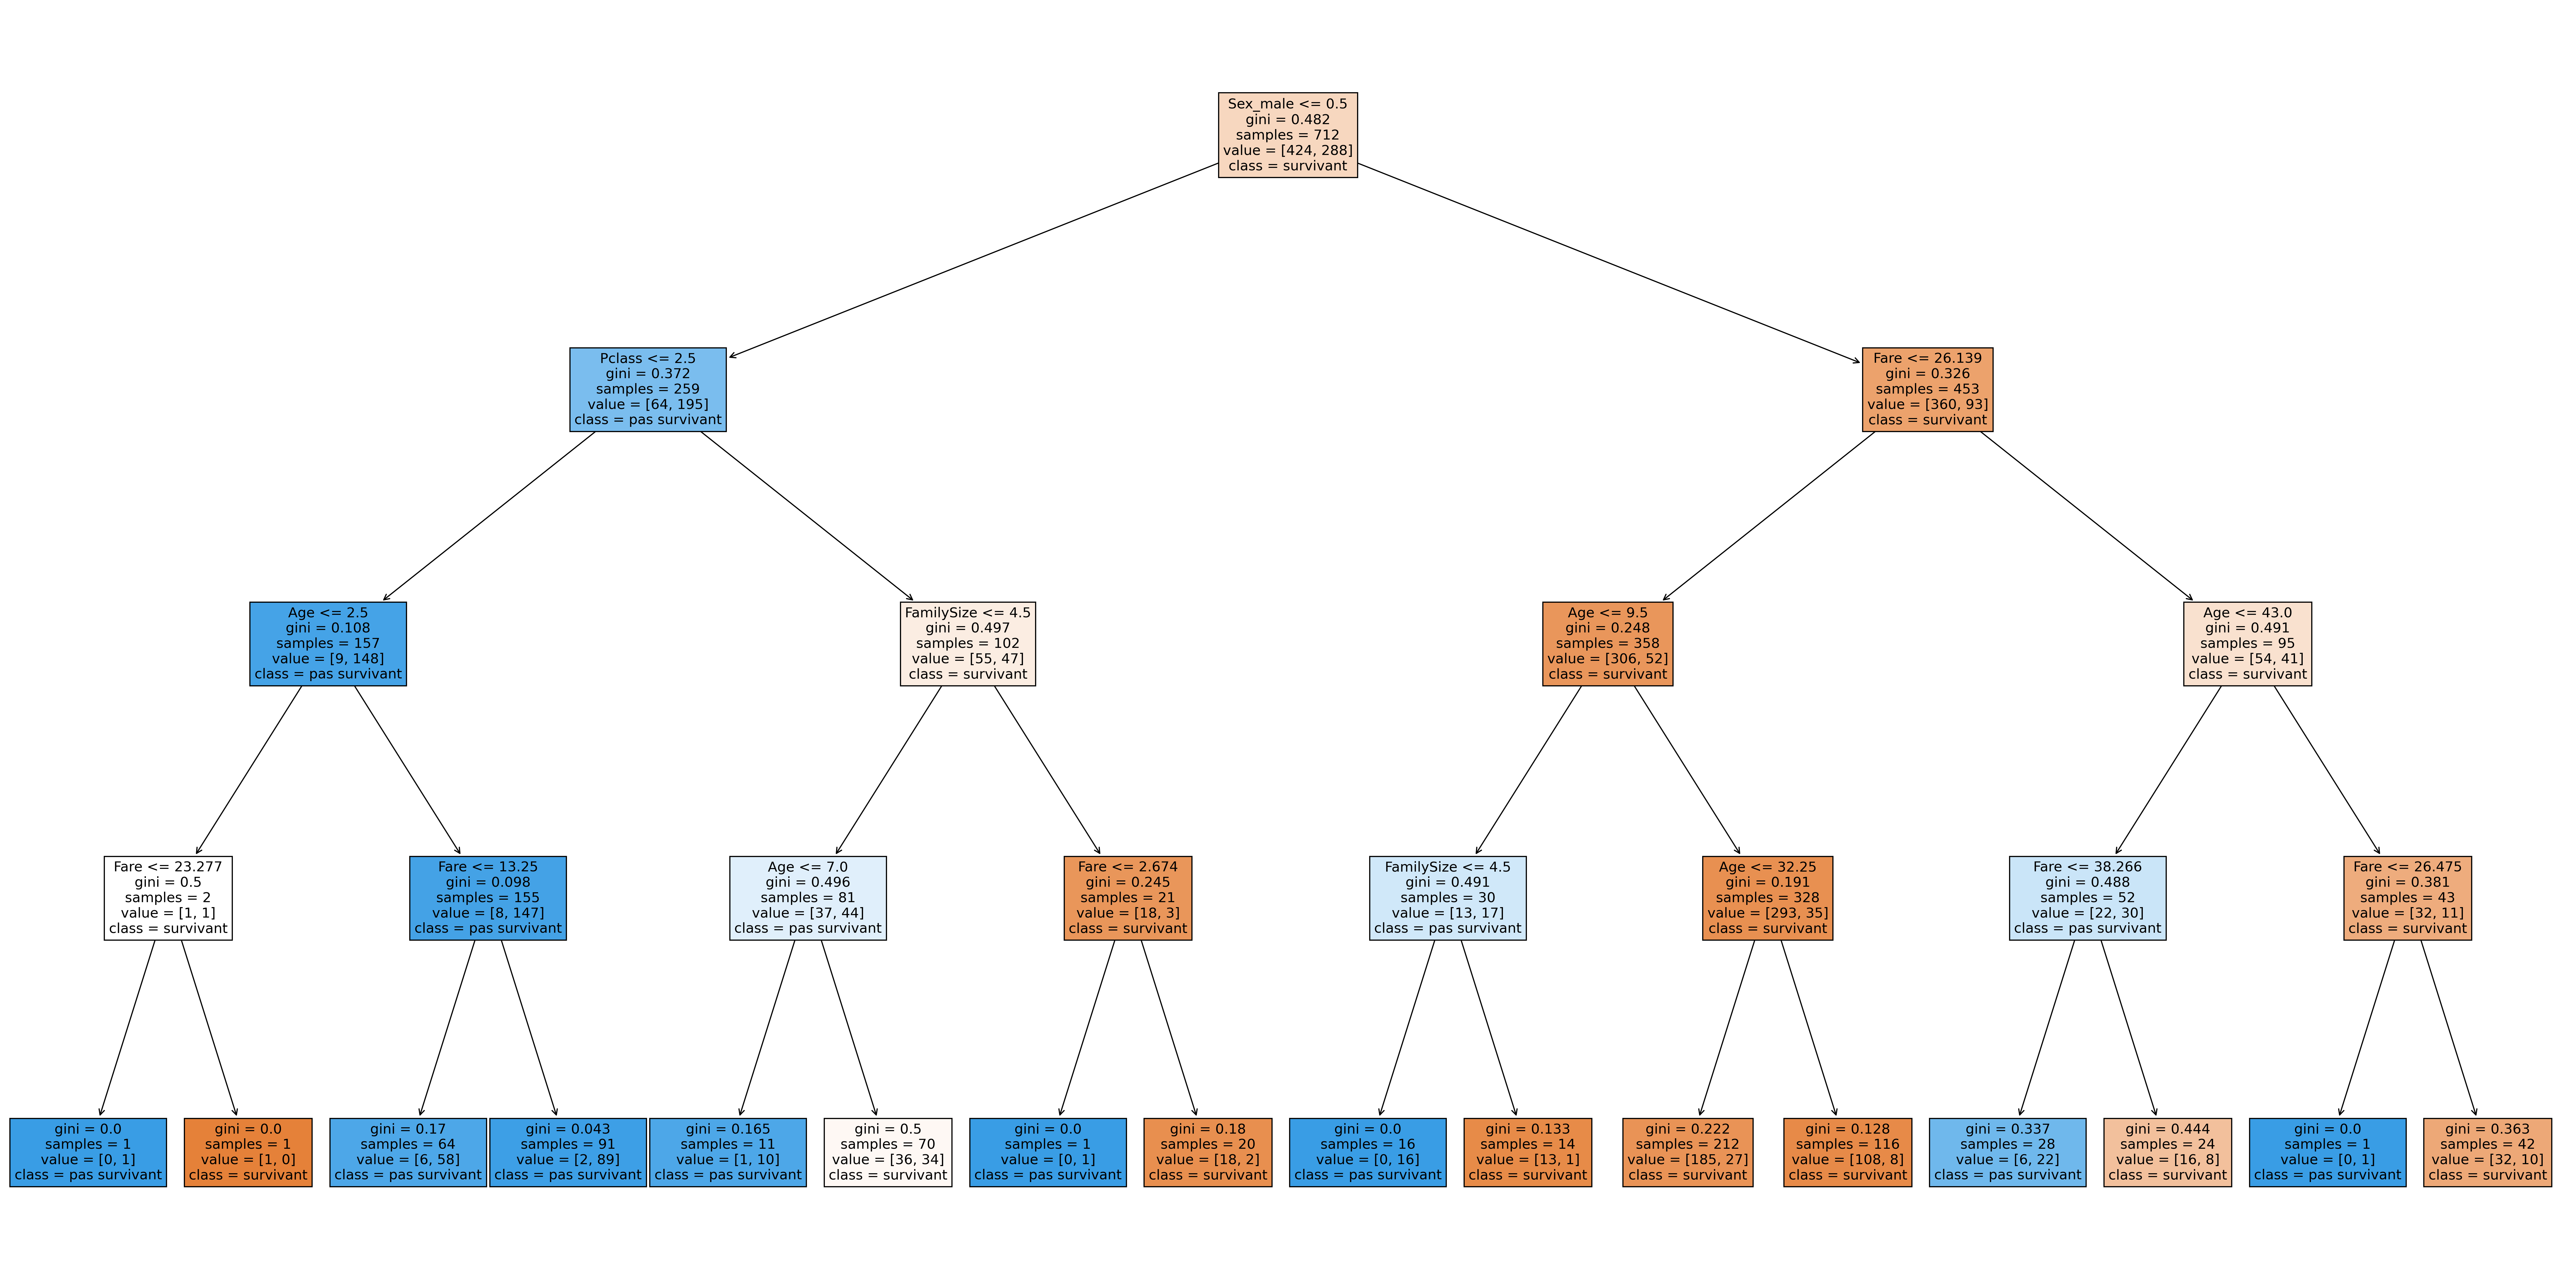

In [93]:
# Générer un model d'arbre de classification
model = DecisionTreeClassifier(max_depth=4)

# On reprend les features X & y de la régression logistique et on fit le model
model_fit = model.fit(X, y)

# Visualiser l'arbre
fig = plt.figure(figsize=(40, 20), dpi=300)
_ = plot_tree(
    model,
    feature_names=X.columns.tolist(),
    class_names=["survivant", "pas survivant"],
    filled=True,
    fontsize=12
)

### Explication des décisions

L'image fournie illustre un arbre de décision de classification, un modèle d'apprentissage automatique utilisé pour prédire la survie des passagers du Titanic, probablement basé sur un ensemble de données classique. L'arbre utilise des caractéristiques telles que le sexe, l'âge, le tarif du billet et la taille de la famille pour faire des prédictions, avec une profondeur maximale de quatre niveaux.
La racine de l'arbre révèle que le sexe est la caractéristique la plus déterminante, les femmes ayant une plus grande probabilité de survie. Pour les passagères, l'âge est le deuxième critère le plus important, en particulier pour les enfants de moins de 2,5 ans. Pour les hommes, le tarif du billet est un indicateur de survie, suggérant que ceux qui ont payé un tarif inférieur ou égal à 26,125 étaient moins susceptibles de survivre. Les niveaux suivants affinent la prédiction en se basant sur la taille de la famille et le tarif pour les deux sexes, reflétant l'impact du statut socio-économique et de la présence familiale.
Chaque nœud de l'arbre fournit des informations sur l'impureté de Gini, le nombre d'échantillons, la distribution des classes et la classe prédominante, offrant une prédiction de survie. Cet arbre permet de comprendre les caractéristiques influençant la survie et de prédire l'issue pour un passager donné, tout en reflétant les biais inhérents aux données sur lesquelles il a été entraîné.

### Conclusion: Interpréter les résultats des deux analyses statistiques et résumer les points importants de votre étude.

La p-valeur élevée associée à la corrélation entre l'âge et le prix du billet suggère que la survie du passager semble être indépendante de la variable "Prix". Cela signifie que, selon l'analyse de corrélation, il n'y a pas de relation linéaire significative entre le prix du billet et la probabilité de survie.
La conclusion basée sur l'analyse préliminaire des données suggère que la probabilité de survie des passagers semble être indépendante du prix du billet. Certaines variables, telles que la classe passagère, l'âge et le sexe, montrent des différences significatives dans la probabilité de survie. Cependant, des analyses statistiques plus approfondies sont nécessaires pour confirmer ces observations et évaluer plus précisément l'impact de chaque variable sur la survie des passagers.